<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture Stochastic Gradient Langevin Dynamics

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

## Outline for today

* How SGD can be modified as a sampler for neural networks? 

**Reading material**: This notebook + (Murphy's advanced book, chapter Part II Inference)

## Recap: Hamiltonian Monte Carlo (HMC)

- A Hamiltonian mechanical system can be imagined as a ball rolling in a frictionless bowl

- By updating the new states by simulating trajectories shown in the figure

- This **efficiently explores** the target distribution and **increases acceptance rates** by following energy-preserving paths.
<img src="figures/hmc.png" title="Hamiltonian mechanics" width="30%" align="center">
<!-- <img align=center src="./figures/hmc.png" width=20%>  -->



In [1]:
import torch
import copy
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Optimizer

class SGLD(Optimizer):
    """Langevin Stochastic Gradient Descent optimizer. It is used for
    bayesian neural networks. It is a variant of SGD optimizer.

    References
    ----------
    Welling, M., & Teh, Y. W. (2011). "Bayesian learning via stochastic
    gradient Langevin dynamics". In Proceedings of the 28th International
    Conference on International Conference on Machine Learning (pp. 681-688).
    """

    def __init__(self,
                 params: dict,
                 lr: float,
                 nesterov: bool = False) -> None:
        """Initialization of Langevin SGD

        Parameters
        ----------
        params : dict
            A dictionary containing the parameters to optimize.
        lr : float
            Learning rate. Must be positive.
        nesterov : bool, optional
            Whether to use Nesterov momentum, by default False.

        Raises
        ------
        ValueError
            If the learning rate is non-positive.
        """

        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        self.netstrov = nesterov
        super(SGLD, self).__init__(params, defaults)

    def __setstate__(self, state) -> None:
        super(SGLD, self).__setstate__(state)
        """Set the state of the optimizer.

        Parameters
        ----------
        state : dict
            The state dictionary containing optimizer state information.
        """
        # change default state values for param groups
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None) -> float:
        """Perform a single optimization step.

        Parameters
        ----------
        closure : callable, optional
            A closure that re-evaluates the model and returns the loss,
            by default None.

        Returns
        -------
        float or None
            The loss value if a closure is provided, otherwise None.
        """
        loss = None
        # first case
        if closure is not None:
            loss = closure()
        # loop over the parameters
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                # add unit noise to the weights and bias
                unit_noise = Variable(p.data.new(p.size()).normal_())
                # Langevin dynamics update
                p.data.add_(0.5*d_p, alpha=-group['lr'])
                p.data.add_(unit_noise, alpha=group['lr']**0.5)

        return loss

In [2]:
class pSGLD(Optimizer):
    """Preconditioned Stochastic Gradient Langevin Dynamics optimizer.

    This optimizer/sampler is commonly used for Bayesian neural networks. It is
    a variant of Stochastic Gradient Descent (SGD) and Stochastic Gradient
    Langevin Dynamics (SGLD).

    References
    ----------
    Li, C., Chen, C., Carlson, D., & Carin, L. (2016, February). "
    Preconditioned stochastic gradient Langevin dynamics for deep neural
    networks". In Proceedings of the AAAI conference on artificial intelligence
    (Vol. 30, No. 1).
    """

    def __init__(self,
                 params: dict,
                 lr: float,
                 alpha: float = 0.99,
                 eps: float = 1e-5,
                 nesterov: bool = False) -> None:
        """Initialize the pSGLD optimizer.

        Parameters
        ----------
        params : dict
            A dictionary containing the parameters to optimize.
        lr : float
            Learning rate. Must be positive.
        alpha : float, optional
            Coefficient for computing running averages of gradient squares,
            by default 0.99.
        eps : float, optional
            A small constant added for numerical stability, by default 1e-5.
        nesterov : bool, optional
            Whether to use Nesterov momentum, by default False.

        Raises
        ------
        ValueError
            If the learning rate is non-positive.
        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        self.netstrov = nesterov
        super(pSGLD, self).__init__(params, defaults)

    def __setstate__(self, state) -> None:
        super(pSGLD, self).__setstate__(state)
        """Set the state of the optimizer.

        Parameters
        ----------
        state : dict
            The state dictionary containing optimizer state information.
        """
        # change default state values for param groups
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None) -> float:
        """Perform a single optimization step.

        Parameters
        ----------
        closure : callable, optional
            A closure that re-evaluates the model and returns the loss,
            by default None.

        Returns
        -------
        float
            The loss value if a closure is provided, otherwise None.
        """

        loss = None
        if closure is not None:
            loss = closure()
        # loop over the parameters
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                # get the state
                state = self.state[p]

                # initialize the state
                if len(state) == 0:
                    state['step'] = 0
                    state['V'] = torch.zeros_like(p.data)

                # get the state parameters
                V = state['V']
                # get the parameters
                alpha = group['alpha']
                eps = group['eps']
                lr = group['lr']

                # update the state
                state['step'] += 1

                # update parameters
                # update V
                V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)

                # get 1/G use the inplace operation (need division when use it)
                G = V.add(eps).sqrt_()

                # update parameters with 0.5*lr (main update of pSGLD)
                p.data.addcdiv_(d_p, G, value=-lr/2)

                # inject noise to the parameters
                noise_std = torch.sqrt(lr/G)
                noise = Variable(p.data.new(p.size()).normal_())
                p.data.add_(noise_std*noise)

        return loss


In [3]:

class BNN_Sampler:
    def __init__(self, model,  sigma=0.1) -> None:
        self.sigma = sigma
        self.nets = []
        self.log_likelihood = []
        self.model = model
    def define_sampler(self, name = 'sgld', lr=0.01):
        if name == 'sgld':
            self.sampler = SGLD(self.model.parameters(), lr=lr)
        elif name == 'psgld':
            self.sampler = pSGLD(self.model.parameters(), lr=lr)

    def train(self, x, y, burn_in=1000, sample_freq=100, sample_num=10):
        for i in range(burn_in + sample_freq * sample_num):
            self.sampler.zero_grad()
            pred_y = self.model(x)
            loss = self.nll_loss(pred_y, y, self.sigma) + self.model.neg_log_prior()
            loss.backward()
            self.sampler.step()

            if i > burn_in and (i - burn_in) % sample_freq == 0:
                self.nets.append(copy.deepcopy(self.model))
                self.log_likelihood.append(loss.item() - self.model.neg_log_prior().item())

            if i % 100 == 0:
                neg_log_prior = self.model.neg_log_prior().item()
                nll = loss.item() - neg_log_prior
                print(
                    f"Epoch: {i:<5d} | "
                    f"Negative Log Posterior: {loss.item():.4f} | "
                    f"NLL: {nll:.4f} | "
                    f"Negative Log Prior: {neg_log_prior:.4f}"
                )
                
    def predict(self, x):

        responses = []
        for net in self.nets:
            pred = net(x).data.numpy()
            responses.append(pred)
        # get the mean and variance of the responses
        pred_mean = (np.array(responses).mean(axis=0)).reshape(-1, 1)
        # epistemic uncertainty
        epistemic = np.array(responses).std(axis=0).reshape(-1, 1)

        return pred_mean, epistemic

    @ staticmethod
    def nll_loss(pred_y, real_y, sigma):
        """negative log likelihood loss function"""
        sigma = torch.Tensor([sigma])
        loss = 0.5 * torch.log(sigma**2) + \
            0.5 * (pred_y - real_y)**2 / sigma**2 + 0.5 * \
            torch.log(torch.Tensor([2 * torch.pi]))
        loss = loss.sum()

        return loss

## How to improve the efficency of HMC?

**Recall the leap frog update step of HMC**
$$\mathrm{v}_{t+\frac{1}{2}} =\mathrm{v}_{t}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} =  \mathrm{\theta}_{t}+\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+\frac{1}{2}})}{\partial \mathrm{v}}$$

$$\mathrm{v}_{t+1} =\mathrm{v}_{t+\frac{1}{2}}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_{t+1})}{\partial \mathrm{\theta}} $$

- Only first order information been used!!!
- Accept/Reject makes HMC difficult to work at scale!
- *leapfrog* requires more computational cost!


### From Hamiltonian Dynamics to Langevin dynamics
The update rule of Langegevin dynamic modified from *leapfrog =1* is given by:

\begin{align}
\label{eq:langevin_update_step}
    \boldsymbol{\theta}_{t+1} 
    &= \boldsymbol{\theta}_{t} 
    - \frac{\eta^2}{2} \boldsymbol{\Sigma}^{-1} \nabla \mathcal{E}(\boldsymbol{\theta}_{t}) 
    + \eta\, \boldsymbol{\Sigma}^{-1} \boldsymbol{v}_{t} \\
    &= \boldsymbol{\theta}_{t} 
    - \frac{\eta^2}{2} \boldsymbol{\Sigma}^{-1} \nabla \mathcal{E}(\boldsymbol{\theta}_{t}) 
    + \eta\, \sqrt{\boldsymbol{\Sigma}^{-1}}\, \boldsymbol{\epsilon}_{t}
\end{align}

where $\boldsymbol{v}_{t} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma})$ and $\boldsymbol{\epsilon}_{t} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$. 

- When $\boldsymbol{\Sigma} = \boldsymbol{I}$ and $\eta = \sqrt{2}$, the update process reduces to a discretized Langevin diffusion, given by:

\begin{equation}
    \mathrm{d}\boldsymbol{\theta}_{t} = - \nabla \mathcal{E}(\boldsymbol{\theta}_{t})\, \mathrm{d}{t} + \sqrt{2}\, \mathrm{d}\boldsymbol{B}_{t}
\end{equation}

where $\boldsymbol{B}_{t}$ denotes a $d$-dimensional Brownian motion.

### Connection between Langevin dynamic with Stochastic Gradient Decent

**Stochastic Gradient Descent (SGD)**
Recall that for a loss function such as MSE, the **full-batch gradient** is:

$$
\nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) = \frac{1}{N} \sum_{n=1}^{N} \nabla \mathcal{L}_n(\boldsymbol{\theta})
$$



**Mini-Batch Gradient**

In practice, we often use the **mini-batch** technique:

$$
\nabla^B_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) = \frac{1}{B} \sum_{n=1}^{B} \nabla_{\boldsymbol{\theta}} \mathcal{L}_n(\boldsymbol{\theta})
$$

where:
- $B$ = mini-batch size
- Provides an **unbiased estimate** of the full gradient

### Connection between Langevin dynamic with Stochastic Gradient Decent


**Unbiased:** The mini-batch is randomly sampled from the full dataset:

$$
\mathbb{E}_{\mathcal{B}} \left[ \nabla_{\boldsymbol{\theta}}^{B} \mathcal{L}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) \right] = 0
$$




**Diffusion Term (Variance)**: The variance (covariance matrix) of the gradient difference is:

$$
\mathrm{Cov}_{\mathcal{B}} \left[ \nabla_{\boldsymbol{\theta}}^{B} \mathcal{L}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta})\right] =
\mathbb{E}_{\mathcal{B}} \left[ \left( \nabla_{\boldsymbol{\theta}}^B \mathcal{L}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) \right) \left( \nabla_{\boldsymbol{\theta}}^B \mathcal{L}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) \right)^\top \right]
$$



For time step $t$, We define

$$
\boldsymbol{v}_t = \sqrt{\lambda} \left( \nabla\mathcal{L}(\boldsymbol{\theta}_t) - \nabla_B\mathcal{L}(\boldsymbol{\theta}_t) \right)
$$

The **SGD update** becomes

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \lambda \nabla^B \mathcal{L}(\boldsymbol{\theta}_t) 
= \boldsymbol{\theta}_t - \lambda \nabla \mathcal{L}(\boldsymbol{\theta}_t) + \sqrt{\lambda} \boldsymbol{v}_t
$$
where $\lambda$ is the learning rate

### Connection between Langevin dynamic with Stochastic Gradient Decent

**SGD update step**
$$\boldsymbol{\theta}_{t+1} =  \boldsymbol{\theta}_t - \lambda \nabla \mathcal{L}(\boldsymbol{\theta}_t) + \sqrt{\lambda} \boldsymbol{v}_t$$

where $\lambda$ is the learning rate, and $\boldsymbol{v}$ is a diffusion term between mini-batch and full batch.




**Langevin update**

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \frac{\eta^2}{2} \nabla \mathcal{E}(\boldsymbol{\theta}_t) + \eta \, \epsilon_t
$$

where $\eta$ is the step size, and $\epsilon_t$ is the diffusion term following a distribution, usually Gaussian.



**Note: Langevin update can be regarded as injecting noise to SGD, such that SGD can be a sampler**

### Stochastic Gradient Langevin Dynamics (SGLD)

Welling et al. (2011) proposed **SGLD**, a special case of Langevin Monte Carlo (LMC) for posterior inference in BNNs.

- Remind the BNN Posterior:$
p(\boldsymbol{\theta} \mid \mathcal{D}) \propto p(\boldsymbol{\theta}) \prod_{n=1}^{N} p(y_n \mid \boldsymbol{\theta})$
- and: $\mathcal{E}(\boldsymbol{\theta}) = - \mathrm{log} p(\boldsymbol{\theta} \mid \mathcal{D})$


- SGLD update rule

$$
\Delta \boldsymbol{\theta}_t = \frac{\epsilon_t}{2} \nabla\left( \log p(\boldsymbol{\theta}_t ) + \frac{N}{B} \log p(y_i \mid \boldsymbol{\theta}_t)\right) + \eta_t \mathbf{I}
$$

where:

$$
\eta_t \sim \mathcal{N}(\boldsymbol{0}, \epsilon_t)
$$

**It anables to sample posteriors of BNN effiently and at scale**

## Summary of SGLD

- Randomly initialize parameters $\boldsymbol{\theta}_0$
- At each iteration $t$:
  1. Sample a **mini-batch** $\mathcal{B}_t$ from the dataset
  2. Compute stochastic gradient of log-posterior and update with noise:
     $$
     \boldsymbol{\theta}_{t+1} =
     \boldsymbol{\theta}_t +
     \frac{\epsilon_t}{2} \left[
     \nabla \log p(\boldsymbol{\theta}_t) +
     \frac{N}{n} \sum_{i \in \mathcal{B}_t}
     \nabla_{\boldsymbol{\theta}} \log p(y_i \mid \boldsymbol{\theta}_t)
     \right]
     +
     \boldsymbol{\eta}_t
     $$
     where $\boldsymbol{\eta}_t \sim \mathcal{N}(\boldsymbol{0}, \epsilon_t \mathbf{I})$
- After **burn-in**, collect samples $\{\boldsymbol{\theta}_t\}$ as posterior samples. Note that, it works fine with collecting every sample after **burn-in**, but set sample frequency that mimics *leapfrog* of HMC could stablize the sampling. 
- Step size $\epsilon_t$ can be constant (for sampling) or decreasing (for convergence)


### Can we further improve SGLD? 

SGLD works well for large-scale problems like training BNNs. However, it **assumes all parameters** $\boldsymbol{\theta}$ have the same step size.
- Slow convergence
- Even divergence when components of $\boldsymbol{\theta}$ have different curvatures



###  Preconditioned SGLD (pSGLD)

Li et al. (2015) proposed **pSGLD** to address this issue with the following refinements.
- Use a **preconditioning matrix** $G(\boldsymbol{\theta}_t)$ (from RMSprop)  



### pSGLD update rule

$$
\Delta \boldsymbol{\theta}_t =
\frac{\epsilon_t}{2} \left[
G(\boldsymbol{\theta}_t)
\left(\nabla \log p(\boldsymbol{\theta}_t) + \frac{N}{n} \log p(y_i \mid \boldsymbol{\theta}_t) \right)
+ \boldsymbol{\Gamma}(\boldsymbol{\theta}_t)
\right]
+ \eta_t G(\boldsymbol{\theta}_t)
$$

where:

$$
\Gamma_i(\boldsymbol{\theta}) = \sum_j \frac{\partial G_{i,j}(\boldsymbol{\theta})}{\partial \theta_j}
$$

- Preconditioner Definition

$$
G(\boldsymbol{\theta}_{t+1}) =
\mathrm{diag} \left(
\boldsymbol{1} \oslash
\left( \lambda \boldsymbol{1} + \sqrt{V(\boldsymbol{\theta}_{t+1})} \right)
\right)
$$

$$
V(\boldsymbol{\theta}_{t+1}) =
\alpha V(\boldsymbol{\theta}_t) +
(1 - \alpha)\,
\bar{g}(\boldsymbol{\theta}_t; \mathcal{B}_t)
\odot
\bar{g}(\boldsymbol{\theta}_t; \mathcal{B}_t)
$$

$$
\bar{g}(\boldsymbol{\theta}_t; \mathcal{B}_t) =
\frac{1}{n} \sum_{i=1}^{n}
\nabla_{\boldsymbol{\theta}} \log p(y_i \mid \boldsymbol{\theta}_t)
$$



### BNN training with SGLD/pSGLD
- Define the toy problem

In [4]:
# Define a one-dimensional problem 
torch.manual_seed(0)
def cubic_sin(x: torch.Tensor, noise_std: float = 0.1) -> torch.Tensor:
    
    obj = torch.sin(6*x)**3 + torch.randn_like(x) * noise_std
    return obj.reshape((-1, 1))

# get the training samples
sample_x1 = torch.linspace(-0.8, -0.2, 16).reshape((-1, 1))
sample_x2 = torch.linspace(0.2, 0.8, 16).reshape((-1, 1))
sample_x = torch.cat([sample_x1, sample_x2], dim=0)
# scale the data
x_mean = sample_x.mean(); x_std = sample_x.std()
sample_x_scaled = (sample_x - x_mean) / x_std
# get the responses
sample_y = cubic_sin(sample_x, noise_std=0.1)
# scale the y
y_mean = sample_y.mean(); y_std = sample_y.std()
sample_y_scaled = (sample_y - y_mean) / y_std

### Define the BNN architecture

In [5]:

class BNN(nn.Module):
    """A two layer MLP"""
    def __init__(self,input_dim, hidden_dim, output_dim, prior_mu, prior_sigma):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        
    def forward(self, x):
        """A forward pass to get a prediction of a particular step"""
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def neg_log_prior(self):
        prior_loss = 0
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # prior distribution
                dist = torch.distributions.Normal(self.prior_mu, self.prior_sigma)
                # prior loss
                prior_loss = prior_loss +  dist.log_prob(m.weight).sum() + dist.log_prob(m.bias).sum()
        return -prior_loss

### Train BNN

In [6]:
# define the nueral architecture, the prior distribution of weights is N(0,1^2)
network = BNN(input_dim=1, hidden_dim=256, output_dim=1, prior_mu=0.0, prior_sigma=1.0)
model = BNN_Sampler(model=network, sigma=0.1/y_std) # the sigma is the standard deviation of data uncertainty (known)
# define your sampler
model.define_sampler(name='psgld', lr=0.001)
# train your model
model.train(sample_x_scaled, sample_y_scaled, burn_in=500, sample_freq=20, sample_num=1000)

/tmp/ipykernel_58984/2766845948.py:109: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


Epoch: 0     | Negative Log Posterior: 61872.7656 | NLL: 19.1211 | Negative Log Prior: 61853.6445
Epoch: 100   | Negative Log Posterior: 64909.3359 | NLL: -4.9258 | Negative Log Prior: 64914.2617
Epoch: 200   | Negative Log Posterior: 67317.3516 | NLL: -17.4375 | Negative Log Prior: 67334.7891
Epoch: 300   | Negative Log Posterior: 69554.8516 | NLL: -21.4609 | Negative Log Prior: 69576.3125
Epoch: 400   | Negative Log Posterior: 71733.2969 | NLL: -5.5938 | Negative Log Prior: 71738.8906
Epoch: 500   | Negative Log Posterior: 73874.6719 | NLL: -20.9531 | Negative Log Prior: 73895.6250
Epoch: 600   | Negative Log Posterior: 75947.8906 | NLL: -28.5625 | Negative Log Prior: 75976.4531
Epoch: 700   | Negative Log Posterior: 78020.9219 | NLL: -22.0000 | Negative Log Prior: 78042.9219
Epoch: 800   | Negative Log Posterior: 79914.2969 | NLL: -16.5391 | Negative Log Prior: 79930.8359
Epoch: 900   | Negative Log Posterior: 81644.2656 | NLL: -27.8984 | Negative Log Prior: 81672.1641
Epoch: 1000  

Epoch: 8400  | Negative Log Posterior: 109332.4219 | NLL: 3.9531 | Negative Log Prior: 109328.4688
Epoch: 8500  | Negative Log Posterior: 109272.8438 | NLL: 15.7344 | Negative Log Prior: 109257.1094
Epoch: 8600  | Negative Log Posterior: 109311.2734 | NLL: 28.6484 | Negative Log Prior: 109282.6250
Epoch: 8700  | Negative Log Posterior: 109282.0156 | NLL: 52.6953 | Negative Log Prior: 109229.3203
Epoch: 8800  | Negative Log Posterior: 109192.6016 | NLL: -0.0391 | Negative Log Prior: 109192.6406
Epoch: 8900  | Negative Log Posterior: 109230.9766 | NLL: 28.1250 | Negative Log Prior: 109202.8516
Epoch: 9000  | Negative Log Posterior: 109227.3438 | NLL: 16.7656 | Negative Log Prior: 109210.5781
Epoch: 9100  | Negative Log Posterior: 109210.5078 | NLL: 9.4062 | Negative Log Prior: 109201.1016
Epoch: 9200  | Negative Log Posterior: 109204.3359 | NLL: 19.2969 | Negative Log Prior: 109185.0391
Epoch: 9300  | Negative Log Posterior: 109123.6250 | NLL: 13.4062 | Negative Log Prior: 109110.2188
Ep

Epoch: 16600 | Negative Log Posterior: 108804.7109 | NLL: -4.3359 | Negative Log Prior: 108809.0469
Epoch: 16700 | Negative Log Posterior: 108806.0391 | NLL: -4.9219 | Negative Log Prior: 108810.9609
Epoch: 16800 | Negative Log Posterior: 108816.9453 | NLL: 23.3984 | Negative Log Prior: 108793.5469
Epoch: 16900 | Negative Log Posterior: 108765.9219 | NLL: 16.1172 | Negative Log Prior: 108749.8047
Epoch: 17000 | Negative Log Posterior: 108746.5000 | NLL: 13.8828 | Negative Log Prior: 108732.6172
Epoch: 17100 | Negative Log Posterior: 108815.7266 | NLL: 61.1406 | Negative Log Prior: 108754.5859
Epoch: 17200 | Negative Log Posterior: 108709.9297 | NLL: 33.9531 | Negative Log Prior: 108675.9766
Epoch: 17300 | Negative Log Posterior: 108695.3203 | NLL: -5.0312 | Negative Log Prior: 108700.3516
Epoch: 17400 | Negative Log Posterior: 108827.0859 | NLL: 15.7734 | Negative Log Prior: 108811.3125
Epoch: 17500 | Negative Log Posterior: 108711.1094 | NLL: -2.3047 | Negative Log Prior: 108713.4141


In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prediction():
    test_x = torch.linspace(-1, 1, 100).reshape((-1, 1))
    # scale 
    test_x_scaled = (test_x-x_mean)/x_std.numpy()
    test_y = cubic_sin(test_x, noise_std=0)  # ground truth

    # code here to visualize your result
    pred_mean, epistemic = model.predict(test_x_scaled)
    # scale it back 
    pred_mean = pred_mean*y_std.numpy() + y_mean.numpy()
    epistemic = epistemic*y_std.numpy()
    # plot the result
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(test_x.numpy(), test_y.numpy(),'--', linewidth=2, color='gray',label='True Function')
    ax[0].plot(test_x.numpy(), pred_mean, color='b', label='Prediction')
    ax[0].fill_between(test_x.numpy().reshape(-1), pred_mean.reshape(-1) - 1.96*epistemic.reshape(-1),
                     pred_mean.reshape(-1) + 1.96*epistemic.reshape(-1), alpha=0.2, label='Epistemic')
    ax[0].scatter(sample_x.numpy(), sample_y.numpy(), marker='o', s=40, label='Training Data')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    ax[0].legend()
    ax[1].plot(model.log_likelihood, 'o')
    ax[1].set_xlabel('Order of Posterior samples')
    ax[1].set_ylabel('NLL')

/tmp/ipykernel_58984/818723766.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_x_scaled = (test_x-x_mean)/x_std.numpy()


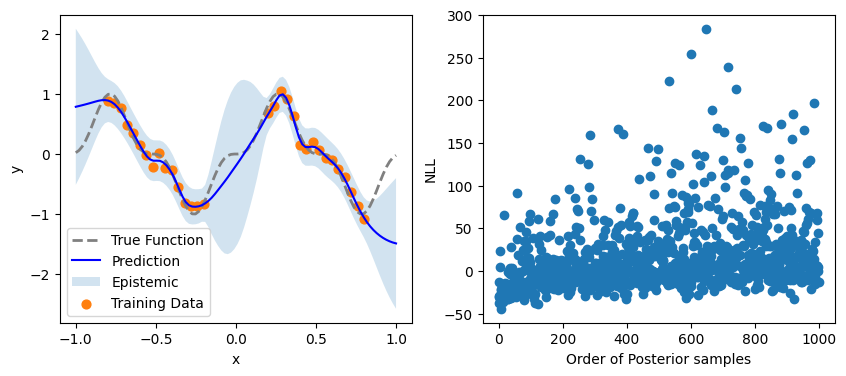

In [18]:
plot_prediction()

### See you next class

Have fun!